In [48]:
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torchvision.models.resnet import resnet34
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt
from tqdm import tqdm

Generating the transition matrix based on random label 1 noisy labels and generating synthetic labels based on it

In [2]:
noisy_path = "../../../data/noisylabels/CIFAR-10_human.pt"
noisy_labels = torch.tensor(torch.load(noisy_path)["random_label1"])
noisy_labels

tensor([6, 9, 9,  ..., 9, 1, 1])

In [3]:
cifar10_train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

clean_dataset = CIFAR10("../../../data/cifar", train=True, transform=cifar10_train_transform)
clean_labels = torch.tensor(clean_dataset.targets)
clean_labels

tensor([6, 9, 9,  ..., 9, 1, 1])

In [4]:
num_classes = 10
T = torch.zeros(num_classes, num_classes)

for i in range(num_classes):
    clean_mask = clean_labels == i
    for j in range(num_classes):
        p = (noisy_labels[clean_mask] == j).float().mean()
        T[i, j] = p
T

tensor([[0.8484, 0.0274, 0.0294, 0.0086, 0.0068, 0.0094, 0.0082, 0.0064, 0.0408,
         0.0146],
        [0.0142, 0.8466, 0.0046, 0.0088, 0.0058, 0.0046, 0.0050, 0.0048, 0.0086,
         0.0970],
        [0.0214, 0.0152, 0.8400, 0.0214, 0.0272, 0.0202, 0.0230, 0.0152, 0.0100,
         0.0064],
        [0.0158, 0.0152, 0.0440, 0.7430, 0.0188, 0.1084, 0.0240, 0.0158, 0.0072,
         0.0078],
        [0.0148, 0.0152, 0.0298, 0.0192, 0.7600, 0.0504, 0.0186, 0.0770, 0.0088,
         0.0062],
        [0.0140, 0.0108, 0.0236, 0.0818, 0.0166, 0.8234, 0.0100, 0.0126, 0.0038,
         0.0034],
        [0.0150, 0.0140, 0.0386, 0.0358, 0.0196, 0.0226, 0.8270, 0.0120, 0.0100,
         0.0054],
        [0.0148, 0.0118, 0.0074, 0.0090, 0.0206, 0.0236, 0.0072, 0.8950, 0.0062,
         0.0044],
        [0.0298, 0.0296, 0.0072, 0.0062, 0.0070, 0.0060, 0.0066, 0.0068, 0.8794,
         0.0214],
        [0.0160, 0.1258, 0.0046, 0.0050, 0.0066, 0.0080, 0.0054, 0.0054, 0.0094,
         0.8138]])

In [5]:
gen = torch.Generator("cpu").manual_seed(1337)
synthetic_labels = torch.multinomial(T[clean_labels], 1, generator=gen).squeeze()
synthetic_labels

tensor([6, 9, 2,  ..., 9, 1, 1])

Training ResNet34 on clean data

In [6]:
model = resnet34(weights=None, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loader = torch.utils.data.DataLoader(clean_dataset, batch_size=128)

num_epochs = 100

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(num_epochs):
    for x, y in (pbar := tqdm(loader, ncols=80, desc=f"{epoch=:3}")):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({"loss": f"{loss.item():.2e}"})

epoch= 99: 100%|███████████████| 391/391 [00:36<00:00, 10.81it/s, loss=4.26e-02]


In [9]:
model_save_path = "model.pt"
torch.save(model, model_save_path)

In [10]:
model = torch.load(model_save_path)

Getting image embeddings

In [12]:
get_graph_node_names(model)

(['x',
  'conv1',
  'bn1',
  'relu',
  'maxpool',
  'layer1.0.conv1',
  'layer1.0.bn1',
  'layer1.0.relu',
  'layer1.0.conv2',
  'layer1.0.bn2',
  'layer1.0.add',
  'layer1.0.relu_1',
  'layer1.1.conv1',
  'layer1.1.bn1',
  'layer1.1.relu',
  'layer1.1.conv2',
  'layer1.1.bn2',
  'layer1.1.add',
  'layer1.1.relu_1',
  'layer1.2.conv1',
  'layer1.2.bn1',
  'layer1.2.relu',
  'layer1.2.conv2',
  'layer1.2.bn2',
  'layer1.2.add',
  'layer1.2.relu_1',
  'layer2.0.conv1',
  'layer2.0.bn1',
  'layer2.0.relu',
  'layer2.0.conv2',
  'layer2.0.bn2',
  'layer2.0.downsample.0',
  'layer2.0.downsample.1',
  'layer2.0.add',
  'layer2.0.relu_1',
  'layer2.1.conv1',
  'layer2.1.bn1',
  'layer2.1.relu',
  'layer2.1.conv2',
  'layer2.1.bn2',
  'layer2.1.add',
  'layer2.1.relu_1',
  'layer2.2.conv1',
  'layer2.2.bn1',
  'layer2.2.relu',
  'layer2.2.conv2',
  'layer2.2.bn2',
  'layer2.2.add',
  'layer2.2.relu_1',
  'layer2.3.conv1',
  'layer2.3.bn1',
  'layer2.3.relu',
  'layer2.3.conv2',
  'layer2.3.bn2

In [13]:
model.eval()
feature_extractor = create_feature_extractor(model, {"flatten": "embeddings"})
n_repeats = 10


embs = []
for _ in range(n_repeats):
    with torch.no_grad():
        embs_ = []
        for x, _ in loader:
            x = x.to(device)
            emb = feature_extractor(x)["embeddings"]
            embs_.append(emb.cpu())
        embs_ = torch.cat(embs_)
    embs.append(embs_)

In [16]:
embs[0].shape

torch.Size([50000, 512])

Clustering the embeddings and plotting the results

In [18]:
cifar_class_names = ["airplanes", "cars", "birds", "cats", "deer", "dogs", "frogs", "horses", "ships", "trucks"]

def generate_ps(noised_labels, embs, num_clusters=5):
    # normalizing embeddings is the same as using cosine distance
    normalized_embs = embs / (embs ** 2).sum(axis=1, keepdims=True)

    P = torch.zeros(num_classes, num_clusters, num_classes)
    for true_cls in range(num_classes):
        class_embs = normalized_embs[clean_labels == true_cls]
        clusters = KMeans(num_clusters, n_init=10, random_state=1337).fit_predict(class_embs)
        for c in range(num_clusters):
            for i in range(num_classes):
                P[true_cls, c, i] = (noised_labels[clean_labels == true_cls][clusters == c] == i).float().mean()
    return P

def plot_ps(P):
    per_row = 5
    num_classes = P.shape[0]
    fig, axs = plt.subplots(num_classes // per_row, per_row, figsize=(10, 5))
    for i, P_ in enumerate(P):
        ax = axs[i // per_row, i % per_row]
        ax.matshow(P_) # cmap="YlGnBu" for their colormap
        ax.set_title(f"class: {i} ({cifar_class_names[i]})")
    fig.tight_layout()

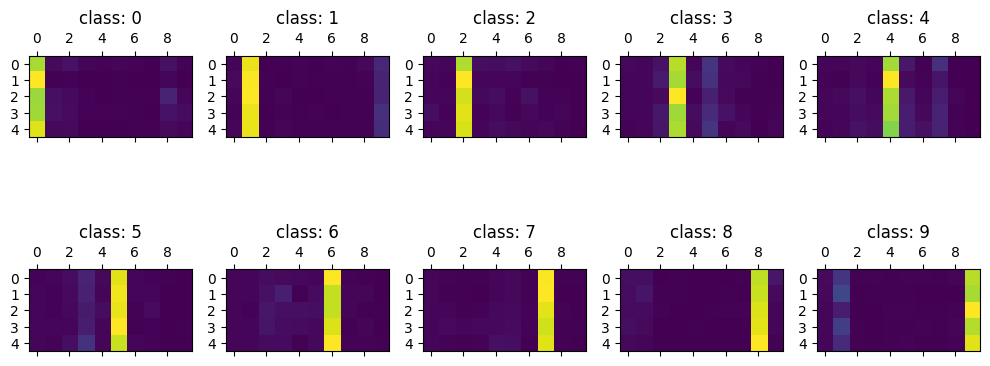

In [19]:
P_human = generate_ps(noisy_labels, embs[0])
plot_ps(P_human)

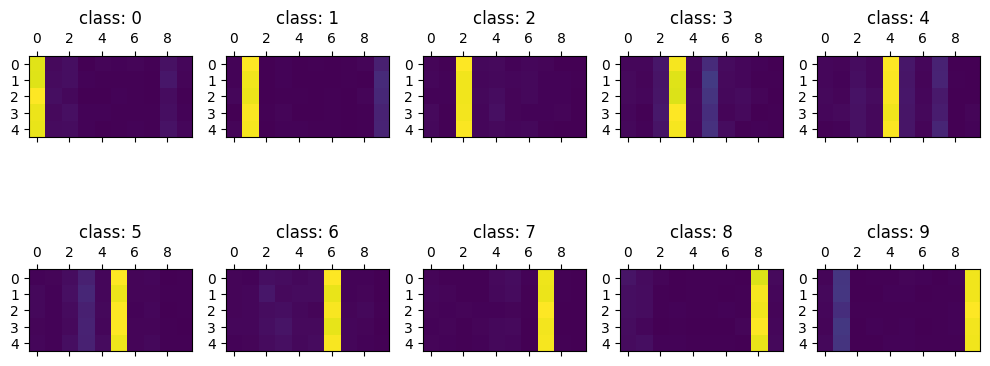

In [20]:
Ps_sythetic = torch.stack([generate_ps(synthetic_labels, emb) for emb in embs])
plot_ps(Ps_sythetic[0])

Getting distances

In [28]:
P_human.shape, Ps_sythetic.shape # [repeats, cls, cluster, cls]

(torch.Size([10, 5, 10]), torch.Size([10, 10, 5, 10]))

In [29]:
d_human = ((P_human - Ps_sythetic) ** 2).sum(axis=-1)
d_human.shape

torch.Size([10, 10, 5])

In [31]:
d_synthetic = ((Ps_sythetic - Ps_sythetic.roll(1, dims=0)) ** 2).sum(axis=-1)
d_synthetic.shape

torch.Size([10, 10, 5])

Hypothesis testing with two sided t-test

In [50]:
pvals = ttest_ind(d_human, d_synthetic, equal_var=False).pvalue
np.argwhere(pvals == pvals.max())

array([[2, 4]])